In [18]:
import pandas as pd
import useful_rdkit_utils as uru
import seaborn as sns
from sklearn.model_selection import RepeatedKFold, ShuffleSplit, KFold
from lightgbm import LGBMClassifier
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import roc_auc_score
import seaborn as sns
from helper import scaffold_split

Read the data

In [19]:
df = pd.read_csv("biogen_logS.csv")

Set up for classification

In [20]:
df['is_sol'] = df.logS >= -4
df.is_sol = df.is_sol.astype(int)

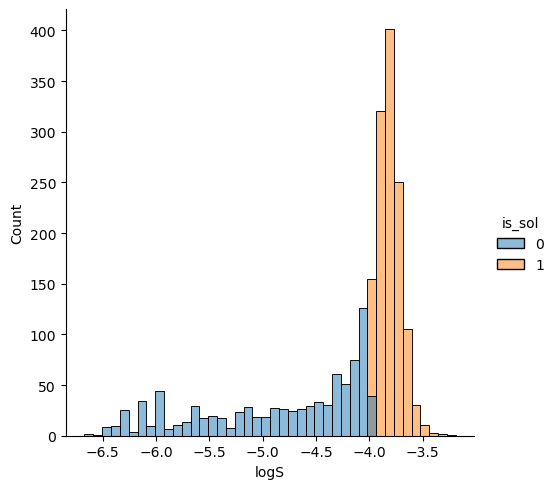

In [21]:
sns.displot(x="logS",hue="is_sol",data=df);

In [22]:
df['fp'] = df.SMILES.apply(uru.smi2numpy_fp)

In [23]:
X_vals = np.stack(df.fp)
y_vals = df.is_sol 

### Repeated K-Fold Cross-Validation

In [24]:
rkf = RepeatedKFold(n_splits=10, n_repeats=5, )
five_x_ten_list = []
for i, (train_index, test_index) in tqdm(enumerate(rkf.split(df)),total=rkf.get_n_splits()):
    train_X = X_vals[train_index]
    train_y = y_vals[train_index]
    test_X = X_vals[test_index]
    test_y = y_vals[test_index]
    cls = LGBMClassifier()
    cls.fit(train_X,train_y)
    pred = cls.predict(test_X)
    auc = roc_auc_score(test_y, pred)
    five_x_ten_list.append(auc)

  0%|          | 0/50 [00:00<?, ?it/s]

In [25]:
five_x_ten_df = pd.DataFrame({"auc": five_x_ten_list, "method": "5x10-fold"})

### Shuffle-Split - This is what train_test_split does

In [26]:
ss = ShuffleSplit(n_splits=10)
ss_list = []
for i, (train_index, test_index) in tqdm(enumerate(ss.split(df)),total=ss.get_n_splits()):
    train_X = X_vals[train_index]
    train_y = y_vals[train_index]
    test_X = X_vals[test_index]
    test_y = y_vals[test_index]
    cls = LGBMClassifier()
    cls.fit(train_X,train_y)
    pred = cls.predict(test_X)
    auc = roc_auc_score(test_y, pred)
    ss_list.append(auc)

  0%|          | 0/10 [00:00<?, ?it/s]

In [27]:
ss_df = pd.DataFrame({"auc": ss_list, "method": "shuffle-split"})

### K-Fold Cross-Validation

In [42]:
kf = KFold(n_splits=10, shuffle=True)
kf_list = []
for i, (train_index, test_index) in tqdm(enumerate(kf.split(df)),total=kf.get_n_splits()):
    train_X = X_vals[train_index]
    train_y = y_vals[train_index]
    test_X = X_vals[test_index]
    test_y = y_vals[test_index]
    cls = LGBMClassifier()
    cls.fit(train_X,train_y)
    pred = cls.predict(test_X)
    auc = roc_auc_score(test_y, pred)
    kf_list.append(auc)

  0%|          | 0/10 [00:00<?, ?it/s]

In [43]:
kf_df = pd.DataFrame({"auc": kf_list, "method": "k-fold"})

### Scaffold Split

In [44]:
scaf_list = []
for i in tqdm(range(0,10)):
    train_index, test_index = scaffold_split(df.SMILES, seed=i)
    train_X = X_vals[train_index]
    train_y = y_vals[train_index]
    test_X = X_vals[test_index]
    test_y = y_vals[test_index]
    cls = LGBMClassifier()
    cls.fit(train_X,train_y)
    pred = cls.predict(test_X)
    auc = roc_auc_score(test_y, pred)
    scaf_list.append(auc)

  0%|          | 0/10 [00:00<?, ?it/s]

In [45]:
scaf_df = pd.DataFrame({"auc": scaf_list, "method": "scaffold"})

In [46]:
combo_df = pd.concat([five_x_ten_df, ss_df, kf_df, scaf_df])

Text(0, 0.5, 'ROC AUC')

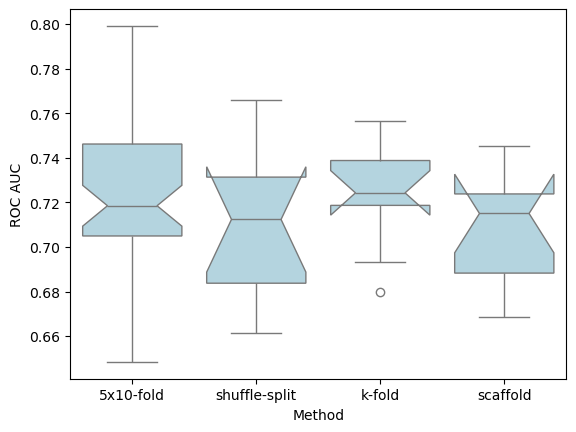

In [47]:
ax = sns.boxplot(x="method",y="auc",data=combo_df,color="lightblue",notch=True)
ax.set_xlabel("Method")
ax.set_ylabel("ROC AUC")